<a href="https://colab.research.google.com/github/torifinch/TimeSeriesAnalysis/blob/main/GroceryStore_TimeSeries_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Unzip the downloaded dataset
!unzip /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip

Archive:  /content/drive/MyDrive/retail_kaggle_data/favorita-grocery-sales-forecasting.zip
  inflating: holidays_events.csv.7z  
  inflating: items.csv.7z            
  inflating: oil.csv.7z              
  inflating: sample_submission.csv.7z  
  inflating: stores.csv.7z           
  inflating: test.csv.7z             
  inflating: train.csv.7z            
  inflating: transactions.csv.7z     


In [3]:
!apt-get install -y p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [4]:
# Extract the files
!7z e train.csv.7z
!7z e stores.csv.7z
!7z e items.csv.7z
!7z e holidays_events.csv.7z
!7z e oil.csv.7z
!7z e transactions.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 474092593 bytes (453 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 474092593
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train.csv                  1% - train.csv                  2% - train.csv                  3% - train.csv                  4% - train.csv                  5% - train.csv                  6% - train.csv                  7% - train.csv                  8% - train.csv

#EDA for Time-series data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('stores.csv')
df_items = pd.read_csv('items.csv')
df_transactions = pd.read_csv('transactions.csv')
df_oil = pd.read_csv('oil.csv')
df_holidays_events = pd.read_csv('holidays_events.csv')

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('train.csv', nrows=2e6)

In [7]:
df_train.shape

(2000000, 6)

## Filtering by Region
Selecting only data for “Guayas” region to further filter our data

In [8]:
# Select list of stores located in the 'Pichincha' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)

# select only 2 000 000 random rows and resetting the index
df_train = df_train.sample(n=2000000)
df_train = df_train.reset_index(drop=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-8-3cc3af8fca1e>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('train.csv', chunksize=chunk_size):


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 91.6+ MB


##Top 3 Families
Selecting only the Top 3 families by the total number of items

In [10]:
# Get the top-3 families by the number of items
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family', 'Item Count']
top_3_families = items_per_family.head(3)  # here is where we get the top-3 families

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]


In [11]:
top_3_families.head()

,Family,Item Count
0,GROCERY I,1334
1,BEVERAGES,613
2,CLEANING,446


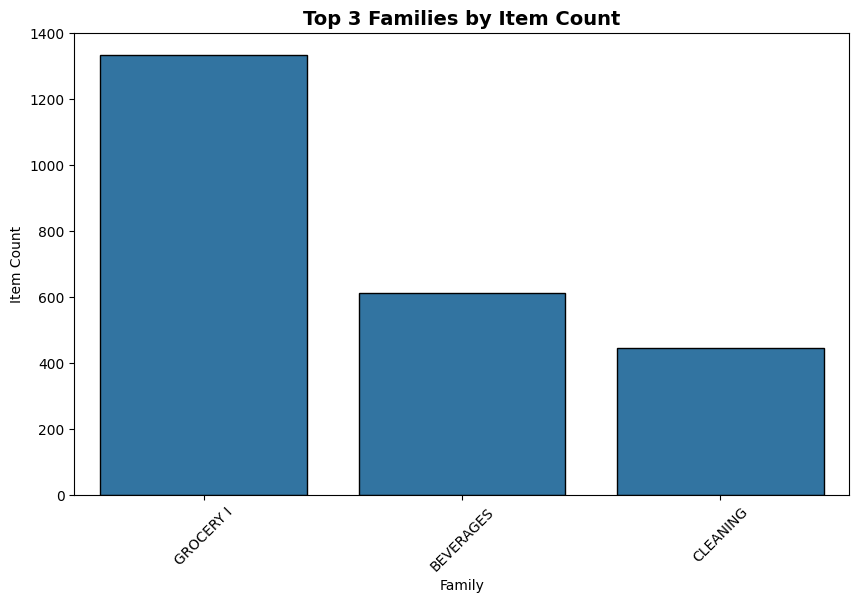

In [12]:
# Plot item count for top 3 families
plt.figure(figsize=(10, 6))
sns.barplot(x='Family', y='Item Count', data=top_3_families, edgecolor='black')
plt.title('Top 3 Families by Item Count', fontsize=14, fontweight='bold')
plt.xlabel('Family')
plt.ylabel('Item Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Loads first 5 rows
df_train.head(5)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,110273175,2017-03-24,51,2017079,1.0,False
1,27943134,2014-07-26,27,213652,3.0,False
2,85177854,2016-07-16,34,1920059,4.0,False
4,30022838,2014-09-01,28,663084,8.0,False
8,22928089,2014-04-26,35,1047756,1.0,False


In [14]:
df_train.shape

(1285763, 6)

##Checking for Missing Data

In [15]:
df_stores.isnull().sum()

,0
store_nbr,0
city,0
state,0
type,0
cluster,0


In [16]:
df_holidays_events.isnull().sum()

,0
date,0
type,0
locale,0
locale_name,0
description,0
transferred,0


In [17]:
df_items.isnull().sum()

,0
item_nbr,0
family,0
class,0
perishable,0


###Oil Price Nulls

Since filling missing oil prices with 0 would distort the data, I will instead forward-fill them using the price from the previous day.

In [18]:
# Check for nulls in df_oil
df_oil.isnull().sum()

,0
date,0
dcoilwtico,43


In [19]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [20]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
# Use bfill to fill the first missing value with the one after it
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

<ipython-input-20-a949b0c92851>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
<ipython-input-20-a949b0c92851>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')


In [21]:
df_oil.isnull().sum()

,0
date,0
dcoilwtico,0


###On Promotion Nulls

Since only nulls are found in the onpromotion column, I will replace them with 0. This approach treats missing promotion data as 'not on promotion,' making the analysis cleaner and more consistent.

In [22]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,240318


In [23]:
df_train['onpromotion'].value_counts()

,count
onpromotion,
False,986117
True,59328


In [24]:
# Replace True/False with 0,1
df_train['onpromotion'] = df_train['onpromotion'].replace({True: 1, False: 0})

<ipython-input-24-6a62a5235973>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].replace({True: 1, False: 0})


In [25]:
df_train['onpromotion'].value_counts()

,count
onpromotion,
0.0,986117
1.0,59328


In [26]:
# replace nan on onpromotion to 0
df_train['onpromotion'] = df_train['onpromotion'].fillna(0)

## Negative sales
Replacing negative sales with 0 to reflect returns as non-sales

In [27]:
# Checking for negative sales (returns)
negative_sales = df_train[df_train['unit_sales'] < 0]

df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
17189,113582849,2017-04-25,26,1105213,-1.0,0.0
26447,26671765,2014-07-07,26,371438,-17.0,0.0
42680,869192,2013-01-23,26,1109391,-1.0,0.0
47917,79633325,2016-05-19,26,1463823,-2.0,0.0
111949,75011671,2016-04-01,27,1168684,-1.0,0.0


##Handling Outliers

Calculate Z-score, checking against > 5, which is a very high threshold.

In [28]:
# Calculate store-item combination Z-score
def calculate_store_item_zscore(group):
    # Compute mean and standard deviation for each store-item group
    mean_sales = group['unit_sales'].mean()
    std_sales = group['unit_sales'].std()

    # Calculate Z-score (avoiding division by zero for standard deviation)
    group['z_score'] = (group['unit_sales'] - mean_sales) / (std_sales if std_sales != 0 else 1)
    return group

# Apply the Z-score calculation to each store-item group without resetting the index
df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)
df_train_grouped.reset_index(drop=True, inplace=True)

# Define threshold for outliers (Z-score > 5)
outliers = df_train_grouped[df_train_grouped['z_score'] > 5]

print(f"Number of outliers detected: {len(outliers)}")
outliers.head()

Number of outliers detected: 3409


<ipython-input-28-24478d938c4b>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
319,14006972,2013-11-15,24,105575,38.0,0.0,5.252811
659,15510387,2013-12-15,24,105737,37.0,0.0,5.217067
979,100866550,2016-12-23,24,108079,21.0,0.0,6.168185
1110,77135998,2016-04-23,24,108786,15.0,0.0,5.461393
1214,37497340,2014-12-16,24,108797,37.0,0.0,8.302947


Plot which dates were the highest for the top item sold in the outliers

In [29]:
# Date with highest outlier sales
top_outlier_date = outliers['date'].value_counts().head(10)
print(top_outlier_date)

date
2016-04-18    84
2016-04-19    58
2016-04-17    51
2016-04-20    35
2016-12-24    33
2014-12-24    28
2016-04-22    27
2014-12-22    26
2015-12-24    25
2015-12-31    23
Name: count, dtype: int64


In [36]:
# holidays in 2016  2016-04
holidays_2016 = df_holidays_events[df_holidays_events['date'].str.startswith('2016-04')]
print(holidays_2016)

           date     type    locale locale_name                    description  \
216  2016-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
217  2016-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
218  2016-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
219  2016-04-16    Event  National     Ecuador               Terremoto Manabi   
220  2016-04-17    Event  National     Ecuador             Terremoto Manabi+1   
221  2016-04-18    Event  National     Ecuador             Terremoto Manabi+2   
222  2016-04-19    Event  National     Ecuador             Terremoto Manabi+3   
223  2016-04-20    Event  National     Ecuador             Terremoto Manabi+4   
224  2016-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
225  2016-04-21    Event  National     Ecuador             Terremoto Manabi+5   
226  2016-04-22    Event  National     Ecuador             Terremoto Manabi+6   
227  2016-04-23    Event  Na

The top outlier dates coincide with the National Holiday, Terremoto Manabi

In [39]:
# See top outlier items
top_outlier_item = outliers['item_nbr'].value_counts().head(5)

top_outlier_item.head()

,count
item_nbr,
153267,14
1246784,12
841842,11
700607,11
1146785,11


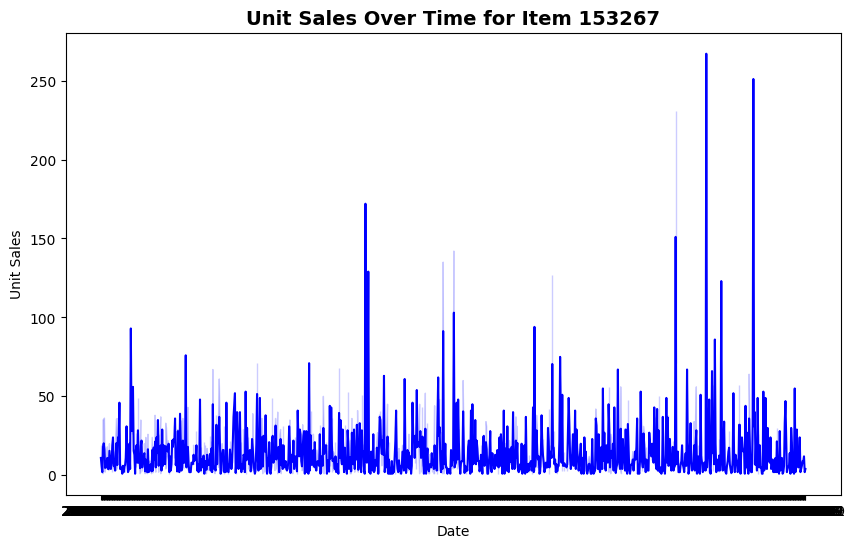

In [40]:
top_outlier = top_outlier_item.index[0]
top_outlier_date = top_outlier_date.index[0]

# Plot top outlier
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='unit_sales', data=df_train[df_train['item_nbr'] == top_outlier], color='blue')
plt.title(f'Unit Sales Over Time for Item {top_outlier}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [41]:
#Check unit sales over 150 per order for top outlier
outliers[(outliers['unit_sales'] > 175) & (outliers['item_nbr'] == top_outlier)]

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
5231,65824015,2015-12-24,24,153267,267.0,0.0,6.897172
5241,15928921,2013-12-23,24,153267,251.0,0.0,6.432599
1134363,100924950,2016-12-23,51,153267,231.0,0.0,8.930520


The top outlier product is sold over re-occuring years at Christmas time.

###Remove Outliers

In [42]:
# Remove outliers
df_train = df_train[~df_train['id'].isin(outliers['id'])]

##Fill missing dates with zero sales

In [43]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})

# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()
all_combinations = store_item_combinations.merge(full_date_range, how='cross')

# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left')

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,51,2017079,2013-01-02,NaN,0.0,NaN
1,51,2017079,2013-01-03,NaN,0.0,NaN
2,51,2017079,2013-01-04,NaN,0.0,NaN
3,51,2017079,2013-01-05,NaN,0.0,NaN
4,51,2017079,2013-01-06,NaN,0.0,NaN


In [44]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
# Use bfill to fill the first missing value with the one after it
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')

<ipython-input-44-a949b0c92851>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='ffill')
<ipython-input-44-a949b0c92851>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_oil['dcoilwtico'] = df_oil['dcoilwtico'].fillna(method='bfill')


## Feature Engineering

###Creating Time-based features
I am creating time-based features like is it a weekend, is it a holiday, and whether it is the day before a holiday hich can also contribute to sales fluctuations.

In [126]:
# Convert 'date' column to datetime in df_holidays_events
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week
df_train['is_weekend'] = (df_train['day_of_week'] >= 5).astype(int)
# is_holiday if type is 'Holiday' in df_holidays_events
df_train['is_holiday'] = df_train['date'].isin(df_holidays_events[df_holidays_events['type'] == 'Holiday']['date']).astype(int)
df_train['is_bridge_day'] = df_train['date'].isin(df_holidays_events[df_holidays_events['type'] == 'Bridge']['date']).astype(int)
df_train['is_day_before_holiday'] = df_train['date'].isin(df_holidays_events[df_holidays_events['type'] == 'Holiday']['date'] - pd.Timedelta(days=1)).astype(int)

###Expanding Window Features

In [47]:
# Expanding Mean
df_train['expanding_mean'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.expanding().mean())


###Adding Columns
Joining oil prices to df_train

In [48]:
# Convert 'date' column in df_oil to datetime before merging
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Join df_oil to df_train
df_train = pd.merge(df_train, df_oil, on='date', how='left')


In [49]:
# Rename dcoilwtico to oil_price
df_train.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

In [50]:
# Fill null values in dcoilwtico using ffill (uses previous value to fill)
df_train['oil_price'] = df_train['oil_price'].fillna(method='ffill')

<ipython-input-50-d633111b2740>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_train['oil_price'] = df_train['oil_price'].fillna(method='ffill')


In [51]:
# Check nulls
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
year,0
month,0
day,0
day_of_week,0


##Smoothing
Using 7 mean smoothed because the data is by day and we want a week at a time.

In [52]:
df_train['rolling_mean_7d'] = df_train['unit_sales'].rolling(window=7).mean()
df_train['rolling_mean_14d'] = df_train['unit_sales'].rolling(window=14).mean()
df_train['rolling_mean_30d'] = df_train['unit_sales'].rolling(window=30).mean()

df_train['rolling_std_7d'] = df_train['unit_sales'].rolling(window=7).std()
df_train['rolling_std_14d'] = df_train['unit_sales'].rolling(window=14).std()
df_train['rolling_std_30d'] = df_train['unit_sales'].rolling(window=30).std()

### Lag features

In [53]:
# Create lag features (e.g., sales from the previous day, previous week)
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_14'] = df_train['unit_sales'].shift(14)

# Drop any rows with NaN values after creating lag features
df_train.dropna(inplace=True)

In [54]:
df_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,oil_price,rolling_mean_7d,rolling_mean_14d,rolling_mean_30d,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14
1282349,64317333,2015-12-08,34,208514,1.0,0.0,2015,12,8,1,...,37.46,5.571429,7.642857,6.766667,7.457818,11.836106,9.205258,1.0,1.0,2.0
1282350,77847348,2016-04-30,51,1119217,3.0,0.0,2016,4,30,5,...,37.46,5.142857,4.714286,6.500000,7.515064,5.552942,9.194264,1.0,6.0,44.0
1282351,2313030,2013-02-27,30,368260,3.0,0.0,2013,2,27,2,...,92.84,5.285714,4.642857,6.533333,7.454625,5.569244,9.179187,3.0,2.0,4.0
1282352,99098416,2016-12-06,29,358519,1.0,0.0,2016,12,6,1,...,50.95,5.000000,4.214286,6.500000,7.593857,5.604649,9.198013,3.0,3.0,7.0
1282353,86423482,2016-07-29,35,608035,5.0,0.0,2016,7,29,4,...,41.54,2.571429,4.500000,6.233333,1.618347,5.529640,9.118694,1.0,22.0,1.0


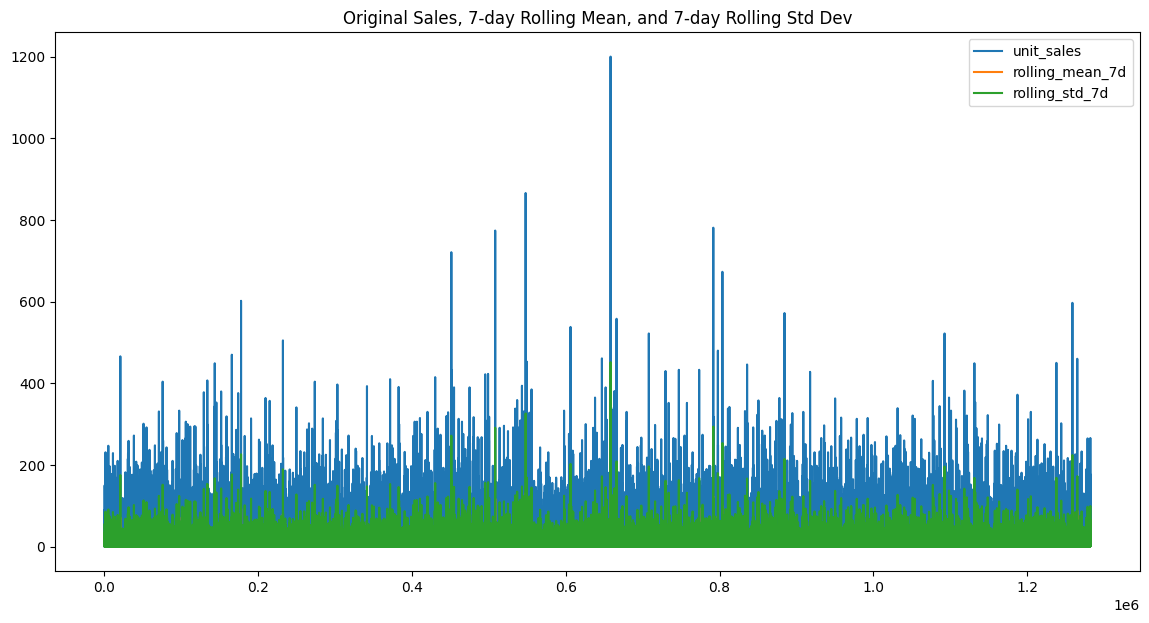

In [55]:
# Visualize the new features alongside the original sales
df_train[['unit_sales', 'rolling_mean_7d', 'rolling_std_7d']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

##Visualizing Time-Series Data

In [56]:
# Visualize the Sales Data over time
plt.figure(figsize=(10, 6))

plt.plot('date', 'unit_sales', data=df_train, color='blue')
plt.title('Sales Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 1000x600 with 1 Axes>

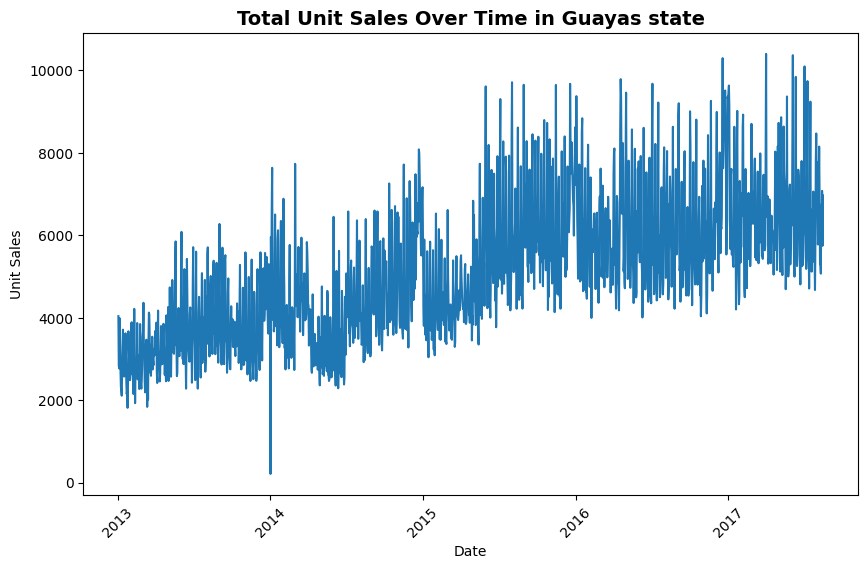

In [57]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(10,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.xticks(rotation=45)

plt.show()

In [58]:
# Aggregating sales by year and month and day
sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

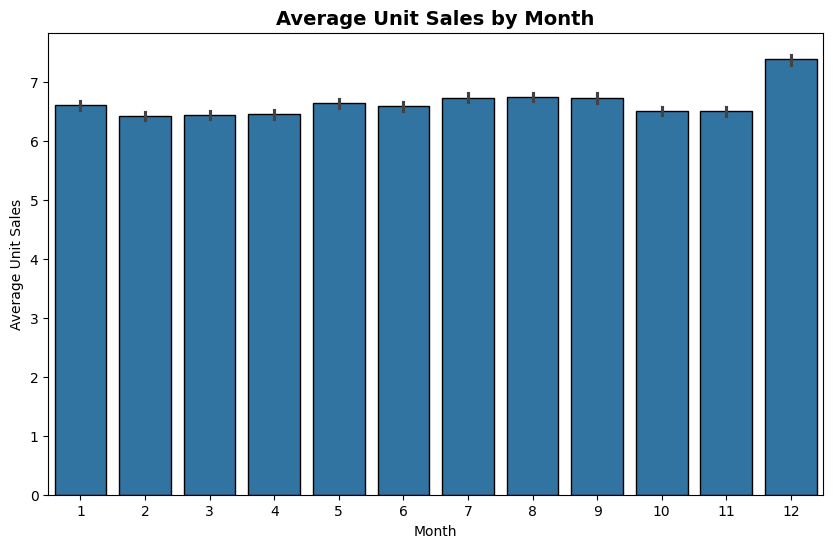

In [70]:
# Plot Avg unit sales by Month
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='unit_sales', data=df_train, edgecolor='black')
plt.title('Average Unit Sales by Month', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average Unit Sales')
plt.show()



There is a bump in December Sales, probably due to Christmas celebrations.

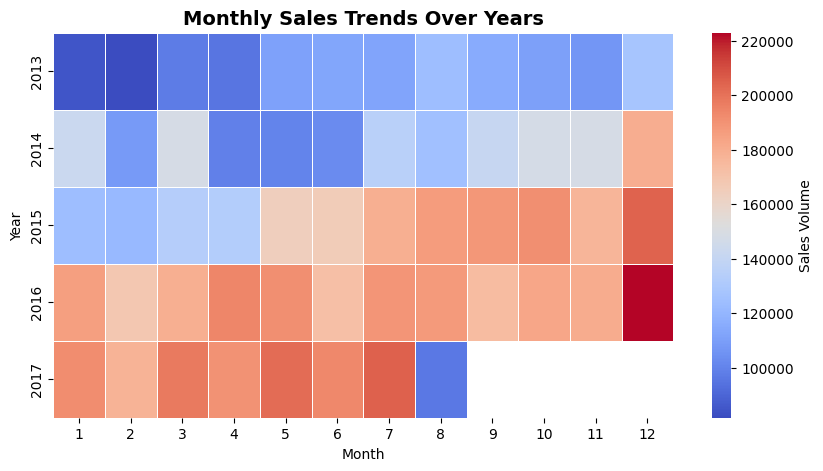

In [59]:
# Plotting heatmap of sales by year and month

plt.figure(figsize=(10, 5))
sns.heatmap(
    sales_by_month,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)

plt.title('Monthly Sales Trends Over Years', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Year')

plt.show()

The 2016/2017 Sales are mostly higher than the previous years. Economic factors could have improved or due to company success.

In [75]:
# Number of store_nbrs by Year
store_years = df_train.groupby('year')['store_nbr'].nunique()
print(store_years)


year
2013    10
2014    10
2015    11
2016    11
2017    11
Name: store_nbr, dtype: int64


No significant increase in the number of stores over the years.

<Axes: xlabel='day', ylabel='year-month'>

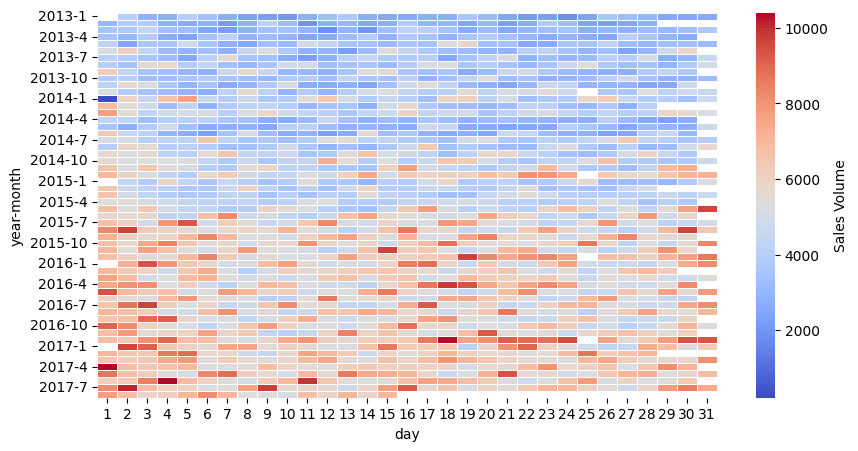

In [71]:
# Plotting heatmap of sales by year and month and day
sales_by_day = df_train.groupby(['year', 'month', 'day'])['unit_sales'].sum().unstack()
plt.figure(figsize=(10, 5))
sns.heatmap(
    sales_by_day,
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Sales Volume'}
)


Christmas Day and New Year's Day are public holidays during which most stores are closed. As a result, it is expected that sales would be significantly lower on these dates.

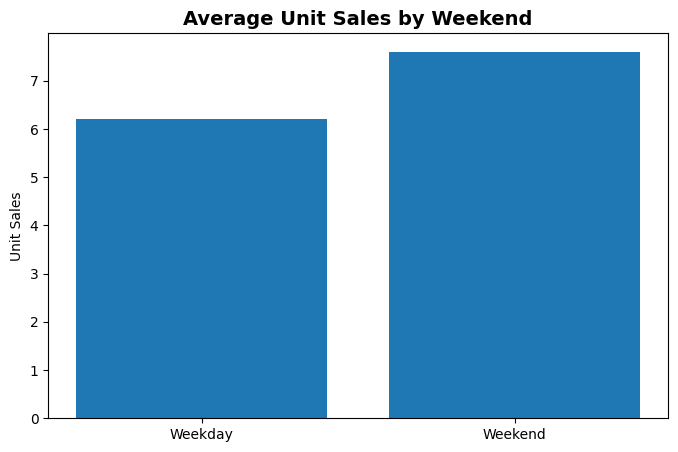

In [76]:
# Avg Sales by Weekend or Weekday using is_weekend
sales_by_weekend = df_train.groupby('is_weekend')['unit_sales'].mean()

# Plotting the sales by weekend
plt.figure(figsize=(8, 5))
plt.bar(sales_by_weekend.index, sales_by_weekend.values)
plt.title('Average Unit Sales by Weekend', fontsize=14, fontweight='bold')
plt.ylabel('Unit Sales')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

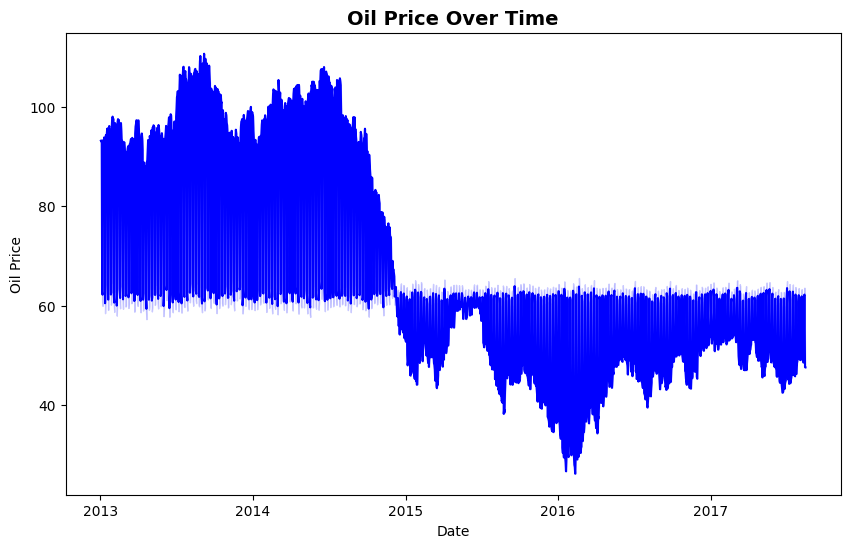

In [77]:
# Oil Price over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='oil_price', data=df_train, color='blue')
plt.title('Oil Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.show()

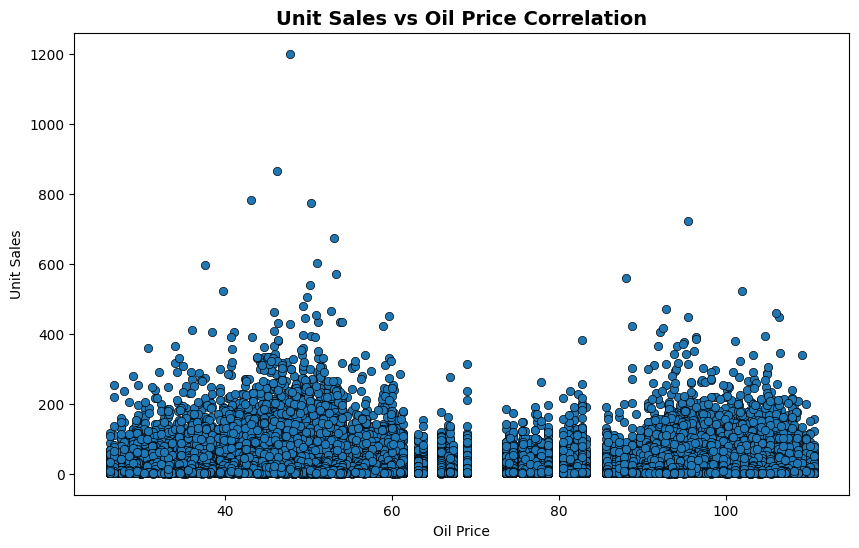

In [78]:
# Sales vs Oil Price correlation graph
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oil_price', y='unit_sales', data=df_train, edgecolor='black')
plt.title('Unit Sales vs Oil Price Correlation', fontsize=14, fontweight='bold')
plt.xlabel('Oil Price')
plt.ylabel('Unit Sales')
plt.show()

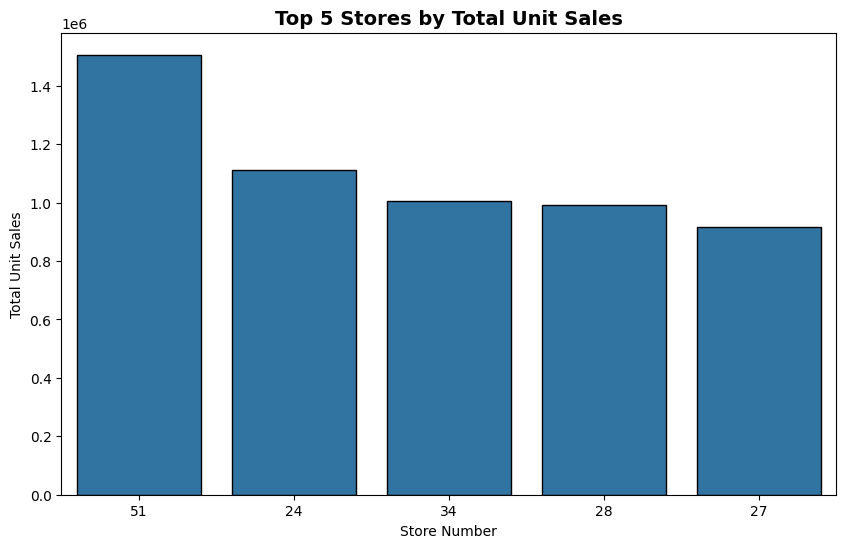

In [79]:
# Stores with highest sales
top_stores = df_train.groupby('store_nbr')['unit_sales'].sum().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stores.index, y=top_stores.values, edgecolor='black', order=top_stores.index)
plt.title('Top 5 Stores by Total Unit Sales', fontsize=14, fontweight='bold')
plt.xlabel('Store Number')
plt.ylabel('Total Unit Sales')
plt.show()

In [80]:
# Find Top Stores Locations
top_stores_locations = df_stores[df_stores['store_nbr'].isin(top_stores.index)]
top_stores_locations

,store_nbr,city,state,type,cluster
23,24,Guayaquil,Guayas,D,1
26,27,Daule,Guayas,D,1
27,28,Guayaquil,Guayas,E,10
33,34,Guayaquil,Guayas,B,6
50,51,Guayaquil,Guayas,A,17


###Guayaquil
Santiago de Guayaquil, is the largest city in Ecuador and also the nation's economic capital and main port.

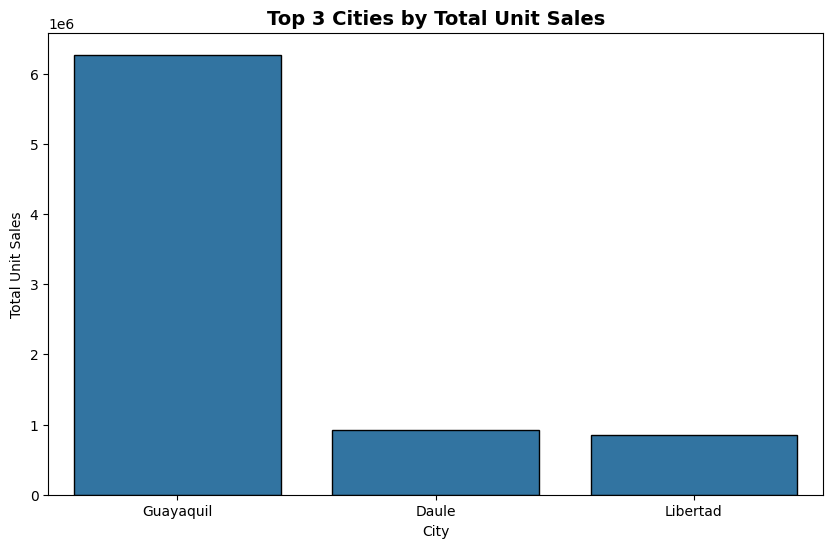

In [81]:
df_stores_train = pd.merge(df_train, df_stores, on='store_nbr', how='left')
#City with highest sales
top_city = df_stores_train.groupby('city')['unit_sales'].sum().nlargest(3)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_city.index, y=top_city.values, edgecolor='black', order=top_city.index)
plt.title('Top 3 Cities by Total Unit Sales', fontsize=14, fontweight='bold')
plt.xlabel('City')
plt.ylabel('Total Unit Sales')
plt.show()

##Examining the Impact of Holidays


In [131]:
# Join holidays and train df
df_train_holiday = pd.merge(df_train, df_holidays_events.astype({'date': 'datetime64[ns]'}), on='date', how='left')
# This ensures both date columns are datetime64[ns] type

In [132]:
# Count values is_weeked
df_train_holiday['is_holiday'].value_counts()

,count
is_holiday,
0,1170664
1,136396


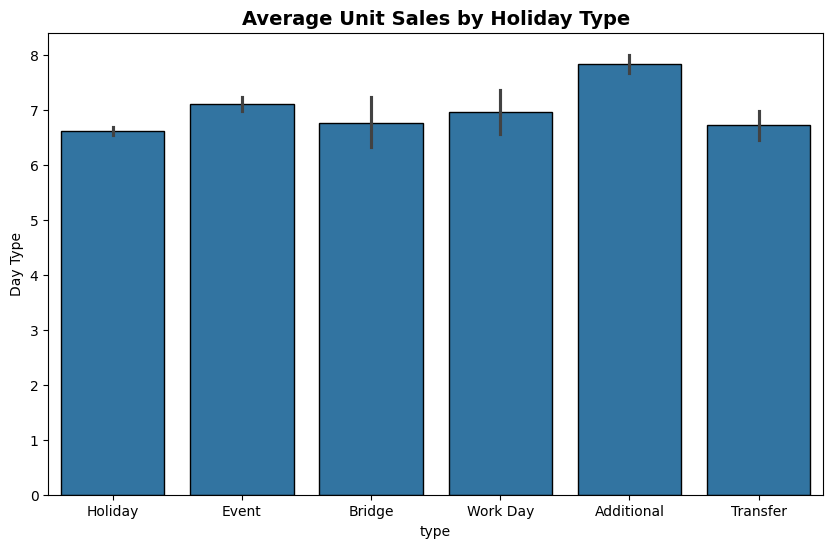

In [133]:
# Avg Sales by holiday type, split by type
plt.figure(figsize=(10, 6))
sns.barplot(x='type', y='unit_sales', data=df_train_holiday, edgecolor='black')
plt.title('Average Unit Sales by Holiday Type', fontsize=14, fontweight='bold')
plt.ylabel('Average Unit Sales')
plt.ylabel('Day Type')
plt.show()


###January 1
Analyzing if Low Sales on January 1 have an impact on Avg Sales of Holidays

In [134]:
# Remove 01-01-2014
df_train_holiday = df_train_holiday[df_train_holiday['date'] != '2014-01-01']

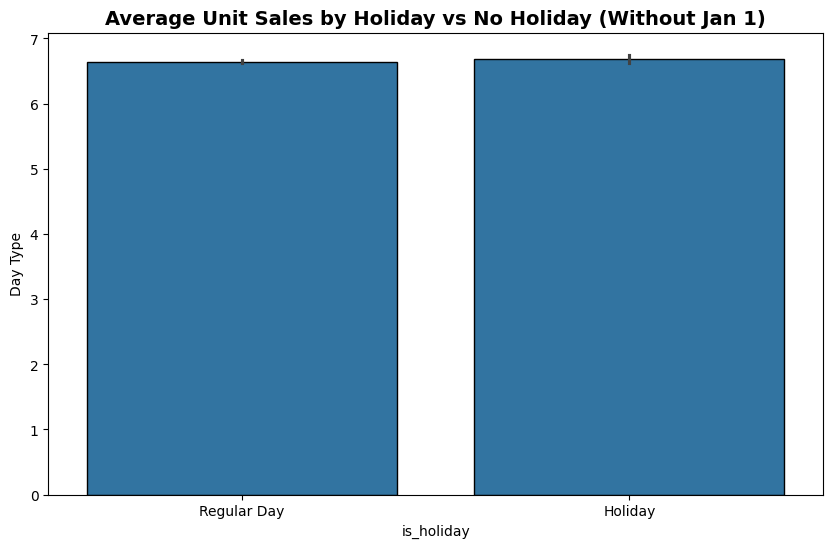

In [135]:
# Avg sales by holiday type, without Jan 1
plt.figure(figsize=(10, 6))
sns.barplot(x='is_holiday', y='unit_sales', data=df_train_holiday, edgecolor='black')
plt.title('Average Unit Sales by Holiday vs No Holiday (Without Jan 1)', fontsize=14, fontweight='bold')
plt.ylabel('Average Unit Sales')
plt.ylabel('Day Type')
plt.xticks([0, 1], ['Regular Day', 'Holiday']) #rename 0,1
plt.show()


Despite low sales, January 1st has no significant affect on the sales average of holiday days.

### Correlation Matrix

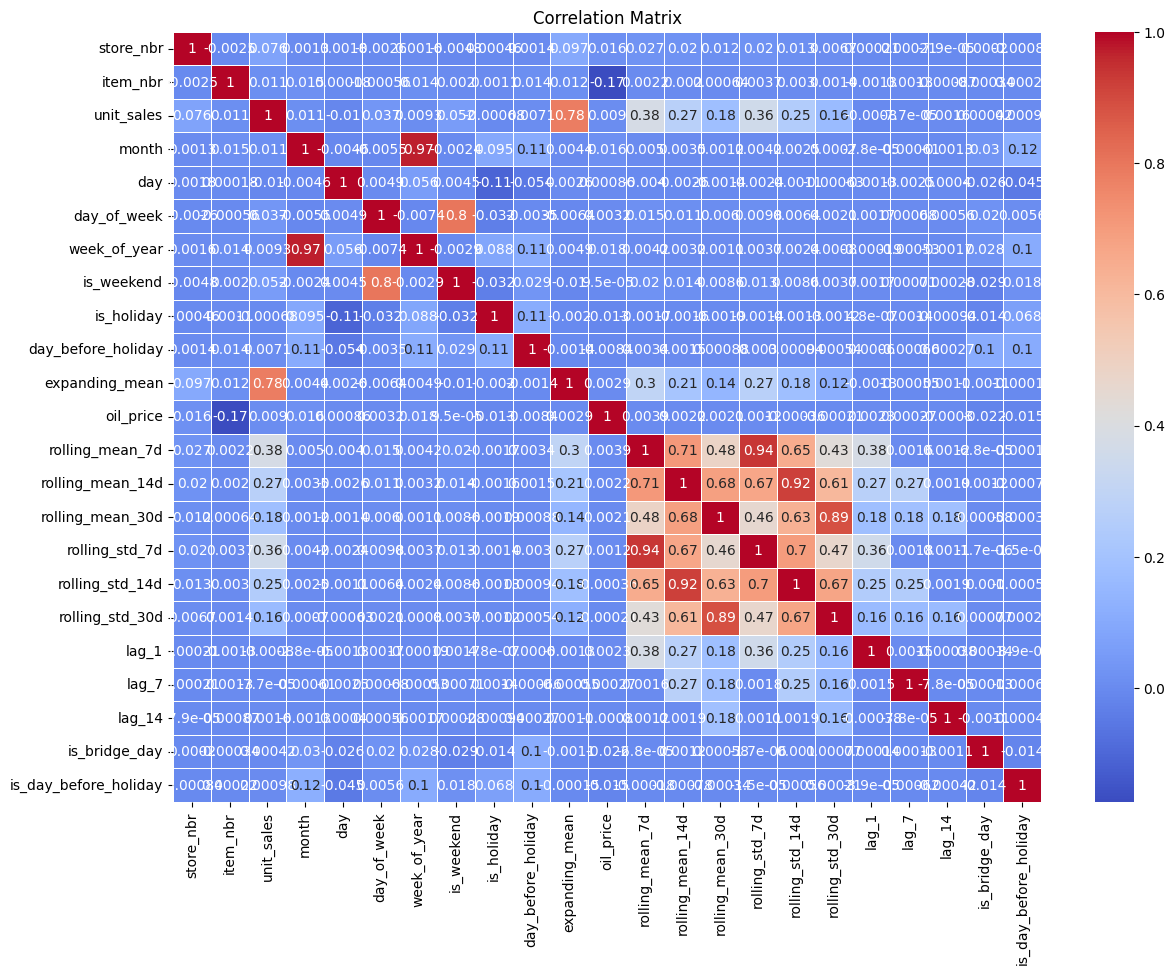

In [138]:
# Remove non-numeric
final_train = df_train.select_dtypes(exclude=['object'])
remove_corr = ['id', 'date', 'onpromotion','year']
final_train_corr = final_train.drop(remove_corr, axis=1)
# Corr Matrix
corr_matrix = final_train_corr.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

##Final Training Dataframe:

In [139]:
# Join Stores and Items to Final DF
final_train = final_train.merge(df_stores, on='store_nbr', how='left')
final_train = final_train.merge(df_items, on='item_nbr', how='left')

In [140]:
# Drop City and State
final_train = final_train.drop(['city', 'state'], axis=1)

In [141]:
# Hot encoding features
final_train = pd.get_dummies(final_train, columns=['family', 'type', 'cluster'], drop_first=True)

In [142]:
# Sort by ['store_nbr', 'item_nbr', 'date']
final_train = final_train.sort_values(['store_nbr', 'item_nbr', 'date'])

In [143]:
# Final df
final_train.tail()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,family_CLEANING,family_GROCERY I,type_B,type_C,type_D,type_E,cluster_3,cluster_6,cluster_10,cluster_17
805621,124669173,2017-08-07,51,2114812,2.0,1.0,2017,8,7,0,...,True,False,False,False,False,False,False,False,False,True
1078645,122131909,2017-07-14,51,2116416,1.0,0.0,2017,7,14,4,...,False,True,False,False,False,False,False,False,False,True
1035238,124970207,2017-08-10,51,2122188,2.0,0.0,2017,8,10,3,...,False,True,False,False,False,False,False,False,False,True
1160605,125179467,2017-08-12,51,2123727,1.0,0.0,2017,8,12,5,...,False,True,False,False,False,False,False,False,False,True
533892,124564703,2017-08-06,51,2127114,21.0,0.0,2017,8,6,6,...,False,False,False,False,False,False,False,False,False,True


In [144]:
final_train.shape

(1282325, 39)

In [145]:
final_train.describe()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,year,month,day,day_of_week,...,rolling_std_7d,rolling_std_14d,rolling_std_30d,lag_1,lag_7,lag_14,is_bridge_day,is_day_before_holiday,class,perishable
count,1.282325e+06,1282325,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,...,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1.282325e+06,1282325.0
mean,6.149746e+07,2015-08-29 19:52:46.009553152,3.245464e+01,9.033057e+05,6.635217e+00,4.556723e-02,2.015177e+03,6.325960e+00,1.562109e+01,3.051270e+00,...,7.926711e+00,8.982185e+00,9.963017e+00,6.635218e+00,6.635237e+00,6.635216e+00,1.898115e-03,9.513267e-02,1.478837e+03,0.0
min,1.879100e+04,2013-01-02 00:00:00,2.400000e+01,9.699500e+04,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,4.688072e-01,1.229896e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.002000e+03,0.0
25%,2.981735e+07,2014-08-28 00:00:00,2.700000e+01,4.224520e+05,2.000000e+00,0.000000e+00,2.014000e+03,3.000000e+00,8.000000e+00,1.000000e+00,...,3.023716e+00,4.276180e+00,5.679263e+00,2.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.034000e+03,0.0
50%,6.086471e+07,2015-11-01 00:00:00,3.000000e+01,8.863980e+05,3.000000e+00,0.000000e+00,2.015000e+03,6.000000e+00,1.600000e+01,3.000000e+00,...,5.159365e+00,6.588785e+00,7.983388e+00,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,1.074000e+03,0.0
75%,9.302839e+07,2016-10-05 00:00:00,3.500000e+01,1.209721e+06,7.000000e+00,0.000000e+00,2.016000e+03,9.000000e+00,2.300000e+01,5.000000e+00,...,9.227289e+00,1.060375e+01,1.177353e+01,7.000000e+00,7.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,1.144000e+03,0.0
max,1.254915e+08,2017-08-15 00:00:00,5.100000e+01,2.127114e+06,1.200000e+03,1.000000e+00,2.017000e+03,1.200000e+01,3.100000e+01,6.000000e+00,...,4.516856e+02,3.196023e+02,2.184012e+02,1.200000e+03,1.200000e+03,1.200000e+03,1.000000e+00,1.000000e+00,3.090000e+03,0.0
std,3.641315e+07,NaN,7.855282e+00,5.233447e+05,1.236268e+01,2.085447e-01,1.311510e+00,3.392524e+00,8.827190e+00,2.024721e+00,...,9.483926e+00,8.490000e+00,7.315311e+00,1.236268e+01,1.236269e+01,1.236268e+01,4.352601e-02,2.933982e-01,7.992275e+02,0.0


In [147]:
# download csv
from google.colab import files
final_train.to_csv('final_train.csv', index=False)
files.download('final_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>